In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams.update({
    'font.size': 15, 'lines.linewidth': 2,
    'xtick.labelsize': 13, 'ytick.labelsize': 13,
    'axes.spines.top': False, 'axes.spines.right': False,
    'savefig.dpi': 1200,
})

import yaml
import numpy as np

from irc.manager import IRCManager
from boxforage.utils import plot_multi_box_episode

# Coupled boxes

In [2]:
manager = IRCManager(defaults='defaults/coupled_boxes.yaml', read_only=True)

## Overview of sweep training over parameter grid

In [3]:
with open('store/c-grid_0.yaml') as f:
    env_param_grid = yaml.safe_load(f)
for i, label in enumerate(['p_appear', 'p_vanish', 'p_true', 'r_food', 'r_move', 'p_couple']):
    print(f'{label}: {env_param_grid[i]}')            
seeds = range(12)
print(f'seeds: {seeds}')

report = manager.overview(env_param_grid=env_param_grid, seeds=seeds, min_epoch=40)

p_appear: [0.1, 0.15, 0.2, 0.25, 0.3]
p_vanish: [0.05, 0.1]
p_true: [0.6, 0.7, 0.8]
r_food: [10.0]
r_move: [-1.0]
p_couple: [-0.4, -0.3, -0.2, -0.1, 0.0, 0.1, 0.2, 0.3, 0.4]
seeds: range(0, 12)
Average progress of training 33.1% (40 epochs as complete).
Approximate training time 46m47.45s per epoch.
Approximate evaluation time 5m29.36s.
Average training optimality 98.6%


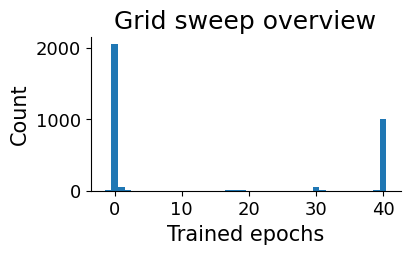

In [4]:
_, ax = plt.subplots(figsize=(4, 2))
ax.hist(report['epoch'], bins=np.arange(min(report['epoch']), max(report['epoch'])+2)-0.5)
ax.set_xlabel('Trained epochs')
ax.set_ylabel('Count')
ax.set_title('Grid sweep overview')
plt.show()

## Inspect a specific agent

Agent (seed 0) was trained for 40 epochs.
mean return 32.82, optimality 99.12%


{'boxes': {'num_boxes': 2,
  'num_shades': 5,
  'p_appear': array([0.3, 0.3]),
  'p_vanish': array([0.1, 0.1]),
  'p_true': array([0.7, 0.7]),
  'p_false': array([0.3, 0.3])},
 'reward': {'food': 10.0, 'fetch': -1.0, 'move': -1.0},
 'couple': {'p': 0.4, 'num_steps': 1}}

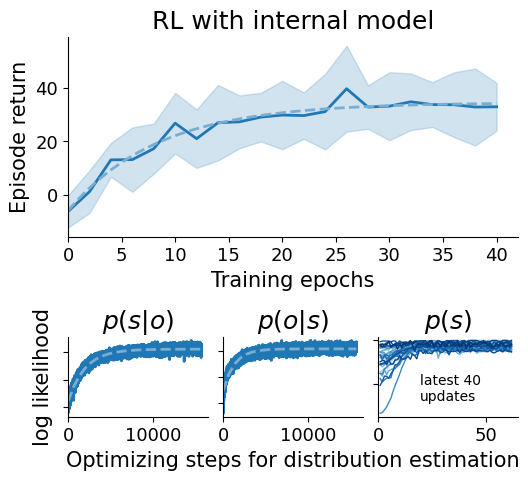

In [5]:
agent, fig = manager.inspect_agent([0.3, 0.1, 0.7, 10.0, -1.0, 0.4], seed=0)

eval_records = manager.ckpt['eval_records']
print('mean return {:.2f}, optimality {:.2%}'.format(
    np.mean(eval_records[max(eval_records.keys())]['returns']), manager.preview['optimality']
))
agent.model.env.spec

## Agent behavior in a real environment

Boxes in the real environment is not coupled $p_\mathrm{couple}=0$, with other parameters the same.

In [6]:
from boxforage.multi_box import SimpleBoxForaging

env = SimpleBoxForaging(spec={'boxes': {'p_appear': 0.3, 'p_vanish': 0.1, 'p_true': 0.7, 'p_false': 0.3}})
env.spec

{'boxes': {'p_appear': array([0.3, 0.3]),
  'p_vanish': array([0.1, 0.1]),
  'p_true': array([0.7, 0.7]),
  'p_false': array([0.3, 0.3]),
  'num_boxes': 2,
  'num_shades': 5},
 'reward': {'food': 10.0, 'fetch': -1.0, 'move': -1.0},
 'couple': {'p': 0.0, 'num_steps': 1}}

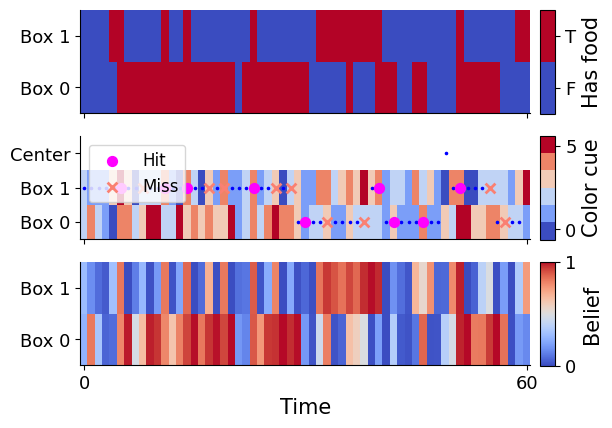

In [7]:
episode = agent.run_one_episode(env=env, num_steps=60)
fig = plot_multi_box_episode(episode)

## Saving and loading behavior data for likelihood computation

### Saving the trial above

In [8]:
actions = episode.pop('actions')
observations = episode.pop('observations')

meta_info = {
    'agent_config': manager.config,
    'real_env': env.spec,
}
meta_info.update(episode)

# ep_key = manager.add_episode(actions, observations, meta_info)
# print(f"Episode data saved as '{ep_key}'.")

### Loading another trial

Loading episode data in 'C6486C'...


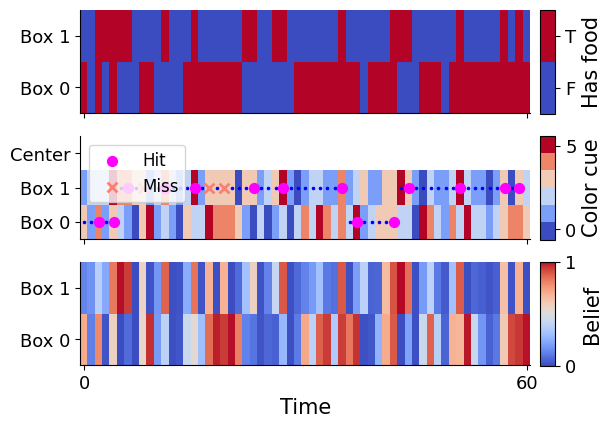

In [9]:
ep_key = 'C6486C'
print(f"Loading episode data in '{ep_key}'...")

episode = manager.episodes[ep_key]
meta_info = episode.pop('meta_info')

# fetch the agent
config = meta_info.pop('agent_config')
manager.setup(config)
manager.load_ckpt()
agent = manager.agent

# create the environment
spec = meta_info.pop('real_env')
env = SimpleBoxForaging(spec=spec)

episode.update(meta_info)
episode = episode.native()
fig = plot_multi_box_episode(episode)

## Compute log likelihoods

Gathering log likelihood of a trial conditioned on different agents and belief updates

In [10]:
for i, label in enumerate(['p_appear', 'p_vanish', 'p_cue', 'r_food', 'r_move', 'p_couple']):
    print(f'{label}: {env_param_grid[i]}')  

logps = manager.compute_likelihoods(
    data_path='C6486C', env_param_grid=env_param_grid,
    agent_seeds=range(3), min_optimality=0.95,
)

nan_ratio = np.isnan(logps).mean()
print('{:.1%} values unfilled'.format(nan_ratio))

p_appear: [0.1, 0.15, 0.2, 0.25, 0.3]
p_vanish: [0.05, 0.1]
p_cue: [0.6, 0.7, 0.8]
r_food: [10.0]
r_move: [-1.0]
p_couple: [-0.4, -0.3, -0.2, -0.1, 0.0, 0.1, 0.2, 0.3, 0.4]
Use default seeds [0, 1, 2, 3, 4, 5, 6, 7] for each run of belief updates.
3.8% values unfilled


In [11]:
from irc.utils import logmeanexp

logps = logps.squeeze()
print('squeezed shape {}'.format(logps.shape))

print('removing the log likelihood values of the true agent...')
p_appear, p_vanish, p_true, p_couple = 0.3, 0.1, 0.7, 0.4
agent_seed = 0
logps[
    env_param_grid[0].index(p_appear),
    env_param_grid[1].index(p_vanish),
    env_param_grid[2].index(p_true),
    env_param_grid[5].index(p_couple),
    agent_seed,
] = np.nan

print('averaging log likelihoods over agent seeds and belief seeds...')
logps = logmeanexp(logps, axis=(-2, -1))

squeezed shape (5, 2, 3, 9, 3, 8)
removing the log likelihood values of the true agent...
averaging log likelihoods over agent seeds and belief seeds...


/usr/local/lib/python3.9/dist-packages/irc/utils.py:177: RuntimeWarning: divide by zero encountered in divide
  y = logsumexp(x, b=1/n, axis=axis, keepdims=keepdims)
/usr/local/lib/python3.9/dist-packages/scipy/special/_logsumexp.py:108: RuntimeWarning: invalid value encountered in multiply
  tmp = b * np.exp(a - a_max)


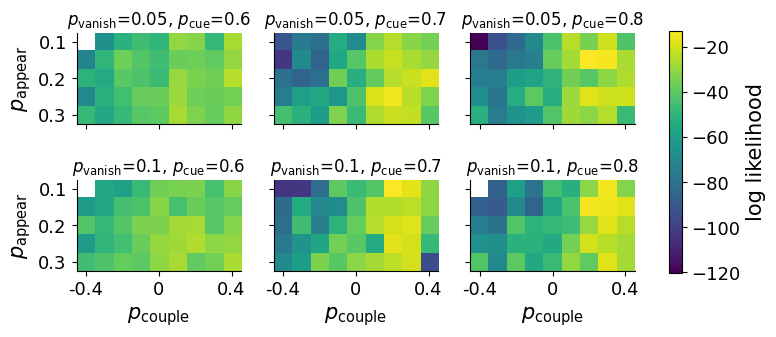

In [12]:
vmin, vmax = np.nanmin(logps), np.nanmax(logps)
_, axes = plt.subplots(2, 3, figsize=(9, 3.5))
for i in range(2):
    for j in range(3):
        ax = axes[i, j]
        h = ax.imshow(logps[:, i, j], vmin=vmin, vmax=vmax)
        ax.set_title(
            r'$p_\mathrm{vanish}$'+'={:g}'.format(env_param_grid[1][i])+', '+r'$p_\mathrm{cue}$'+'={:g}'.format(env_param_grid[2][j]),
            fontsize=12,
        )
        ax.set_xticks([0, 4, 8])
        if i==1:
            ax.set_xlabel(r'$p_\mathrm{couple}$')
            ax.set_xticklabels([-0.4, 0, 0.4])
        else:
            ax.set_xticklabels([])
        ax.set_yticks([0, 2, 4])
        if j==0:
            ax.set_ylabel(r'$p_\mathrm{appear}$')
            ax.set_yticklabels([0.1, 0.2, 0.3])
        else:
            ax.set_yticklabels([])
plt.colorbar(h, ax=axes, shrink=0.9, label='log likelihood')
plt.show()

## Visualize belief distributions

In [13]:
episode = agent.run_one_episode(env=env, num_steps=600)

mean reward 1.770


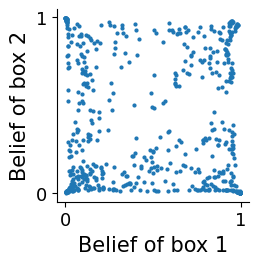

In [14]:
print('mean reward {:.3f}'.format(np.mean(episode['rewards'])))

p_0 = episode['q_probs'][:, [2, 3]].sum(axis=1)
p_1 = episode['q_probs'][:, [1, 3]].sum(axis=1)

_, ax = plt.subplots(figsize=(2.5, 2.5))
ax.scatter(p_0, p_1, s=4)
ax.set_aspect('equal')
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xlabel('Belief of box 1')
ax.set_ylabel('Belief of box 2')
plt.show()